Notebook purpose

- Explore savings, spending, and od fee patterns (for describtive stats, and to sense-check identification of these txns)

In [1]:
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

sns.set_style()

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2


fs = s3fs.S3FileSystem(profile="3di")

month = pd.Grouper(key="date", freq="m")
idx_cols = ["user_id", month]

In [36]:
df = hd.read_txn_data("X77")
dfa = hd.read_analysis_data("X77")
dfs = hd.read_txn_data("777")

Time for read_txn_data                 : 33.54 seconds
Time for read_analysis_data            : 1.12 seconds
Time for read_txn_data                 : 3.19 seconds


In [37]:
dfs

,date,user_id,amount,desc,merchant,tag_group,tag,account_id,account_last_refreshed,account_provider,account_type,debit,female,id,is_sa_flow,is_salary_pmt,is_urban,latest_balance,logins,postcode,region_name,tag_auto,ym,yob
0,2012-02-01,777,400.000000,<mdbremoved> - s/o,NaN,transfers,other_transfers,262916,2020-07-21 20:32:00,natwest bank,current,True,0.0,688300,0,False,1.0,364.220001,0.0,wa1 4,north west,transfers,2012-02,1969.0
1,2012-02-01,777,3.030000,aviva pa - d/d,aviva,spend,finance,262916,2020-07-21 20:32:00,natwest bank,current,True,0.0,688299,0,False,1.0,364.220001,0.0,wa1 4,north west,health insurance,2012-02,1969.0
2,2012-02-03,777,8.750000,chart ins log tran - d/d,NaN,NaN,NaN,262916,2020-07-21 20:32:00,natwest bank,current,True,0.0,688301,0,False,1.0,364.220001,0.0,wa1 4,north west,NaN,2012-02,1969.0
3,2012-02-03,777,0.990000,"9572 02feb12 , apple itunes store, gbp , london gb - pos",apple,spend,services,262916,2020-07-21 20:32:00,natwest bank,current,True,0.0,688303,0,False,1.0,364.220001,0.0,wa1 4,north west,"entertainment, tv, media",2012-02,1969.0
4,2012-02-03,777,20.000000,"9572 02feb12 , national lottery , inte , watford gb - pos",camelot,spend,services,262916,2020-07-21 20:32:00,natwest bank,current,True,0.0,688302,0,False,1.0,364.220001,0.0,wa1 4,north west,gambling,2012-02,1969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651784,2020-07-28,587777,-95.000000,<mdbremoved> bgc,NaN,spend,retail,1711781,2020-08-16 18:36:00,barclays,current,False,0.0,802522114,0,False,1.0,5699.700195,0.0,w7 3,london,refunded purchase,2020-07,1973.0
651785,2020-07-28,587777,5.400000,tfl travel charge tfl.gov.uk/cp,tfl,spend,travel,1711784,2020-08-16 20:35:00,american express,credit card,True,0.0,802887369,0,False,1.0,-1844.410034,0.0,w7 3,london,public transport,2020-07,1973.0
651786,2020-07-28,587777,10.650000,marks & spencer plc st london,marks and spencer,spend,household,1711784,2020-08-16 20:35:00,american express,credit card,True,0.0,802887368,0,False,1.0,-1844.410034,0.0,w7 3,london,"food, groceries, household",2020-07,1973.0
651787,2020-07-31,587777,3.320000,sanef sa stlxxxxx404 ddr,NaN,NaN,NaN,1711781,2020-08-16 18:36:00,barclays,current,True,0.0,803052582,0,False,1.0,5699.700195,0.0,w7 3,london,NaN,2020-07,1973.0


In [ ]:
def add_salary_identifier(df):
    df["is_salary_pmt"] = df.tag_auto.str.contains("salary") & ~df.is_debit
    return df


def add_sa_inflow_identifier(df):
    df["is_sa_inflow"] = (
        df.account_type.eq("savings")
        & ~df.is_debit
        & ~df.tag_auto.str.contains("interest", na=False)
        & ~df.desc.str.contains("save\s?the\s?change")
        & df.amount.ge(5)
    )
    return df


def min_number_of_months(df):
    ym = df.date.dt.to_period("m")
    cond = ym.groupby(df.user_id).size().ge(6)
    users = cond[cond].index
    return df[df.user_id.isin(users)]


def invert_amount_sign(df):
    """Make credits positive."""
    df["amount"] = df.amount * -1
    return df

## Savings

Benchmark

In [10]:
a = ag.savings_accounts_flows(df)

Time for savings_accounts_flows        : 10.20 seconds


In [14]:
b = ag.savings_accounts_flows(df)

Time for savings_accounts_flows        : 1.46 seconds


In [35]:
dfs[dfs.is_sa_flow.eq(1) & ~dfs.is_debit]

,date,user_id,amount,desc,merchant,tag_group,tag,account_id,account_last_refreshed,account_provider,account_type,debit,female,id,is_sa_flow,is_urban,latest_balance,logins,postcode,region_name,tag_auto,ym,yob
5417,2018-06-04,777,-480.0,from a/c xxxx5781 via mobile - xfer - dpc,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,0.0,414297170,1,1.0,164.690002,0.0,wa1 4,north west,transfers,2018-06,1969.0
5538,2018-07-30,777,-420.0,from a/c xxxx5781 via mobile - xfer - dpc,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,0.0,433561934,1,1.0,164.690002,1.0,wa1 4,north west,transfers,2018-07,1969.0
5643,2018-09-06,777,-150.0,from a/c xxxx5781 via mobile - xfer - dpc,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,0.0,449189408,1,1.0,164.690002,0.0,wa1 4,north west,transfers,2018-09,1969.0
6054,2019-02-11,777,-120.0,from a/c xxxx5781 via mobile - xfer - dpc,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,0.0,512170715,1,1.0,164.690002,0.0,wa1 4,north west,transfers,2019-02,1969.0
6055,2019-02-11,777,-60.0,from a/c xxxx5781 via mobile - xfer - dpc,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,0.0,512170716,1,1.0,164.690002,0.0,wa1 4,north west,transfers,2019-02,1969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610962,2018-12-28,570777,-100.0,<mdbremoved> ft|||,NaN,NaN,other_transfers,1592399,2020-05-09 17:18:00,barclays,savings,False,0.0,707360731,1,1.0,0.040000,0.0,wa5 8,north west,NaN,2018-12,1979.0
611061,2019-01-29,570777,-100.0,<mdbremoved> ft|||,NaN,NaN,other_transfers,1592399,2020-05-09 17:18:00,barclays,savings,False,0.0,707360729,1,1.0,0.040000,0.0,wa5 8,north west,NaN,2019-01,1979.0
611270,2019-03-30,570777,-80.0,<mdbremoved> bgc|||,NaN,transfers,savings,1592399,2020-05-09 17:18:00,barclays,savings,False,0.0,707360724,1,1.0,0.040000,0.0,wa5 8,north west,savings (general),2019-03,1979.0
611271,2019-03-30,570777,-100.0,<mdbremoved> ft|||,NaN,NaN,other_transfers,1592399,2020-05-09 17:18:00,barclays,savings,False,0.0,707360725,1,1.0,0.040000,0.0,wa5 8,north west,NaN,2019-03,1979.0


# old

## Savings

In [66]:
def sa_inflows(df):
    return df[df.is_sa_inflow]


dfs = sa_inflows(df)
hd.inspect(dfs)

(8,171, 21)


,date,user_id,amount,desc,merchant,tag_group,tag,account_id,account_last_refreshed,account_provider,account_type,debit,desc_orig,female,id,latest_balance,postcode,tag_auto,yob,is_salary_pmt,is_sa_inflow
5417,2018-06-04,777,480.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,from a/c xxxx5781 via mobile - xfer - dpc,0.0,414297170,164.690002,wa1 4,transfers,1969.0,False,True
5538,2018-07-30,777,420.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,from a/c xxxx5781 via mobile - xfer - dpc,0.0,433561934,164.690002,wa1 4,transfers,1969.0,False,True


### Sumstats of number and amount of monthly inflows

In [67]:
def sa_inflows_per_month(df):
    df = df.copy()
    df["amount"] = df.amount
    month = pd.Grouper(key="date", freq="m")
    return (
        df.groupby(["user_id", month])
        .amount.agg([("txns", "count"), ("amount", "sum")])
        .groupby("user_id")
        .agg(
            [
                "mean",
                "median",
                "min",
                "max",
                "std",
                "size",
            ]
        )
    )


sa_inflows_per_month(dfs).describe().T

count          mean           std   min         25%  \
txns   mean    150.0      2.563240      4.454460   1.0    1.200000   
       median  150.0      2.213333      4.158095   1.0    1.000000   
       min     150.0      1.220000      0.954467   1.0    1.000000   
       max     150.0      6.193333     17.166260   1.0    2.000000   
       std     141.0      1.434325      2.941463   0.0    0.500000   
       size    150.0     15.340000     14.526454   1.0    4.250000   
amount mean    150.0   2352.981689   4851.298340  23.9  324.541664   
       median  150.0   1412.991211   3432.586426  20.0  200.000000   
       min     150.0    582.695496   2560.681396   5.0   40.000000   
       max     150.0  12755.728516  43098.941406  23.9  794.057480   
       std     141.0   3429.154606  11035.018378   0.0  275.064538   
       size    150.0     15.340000     14.526454   1.0    4.250000   

                       50%          75%            max  
txns   mean       1.654762     2.583333      51.928571  
       median     1.000000     2.000000      48.000000  
       min        1.000000     1.000000       8.000000  
       max        3.000000     6.000000     208.000000  
       std        0.919327     1.468759      32.673098  
       size      11.000000    20.500000      80.000000  
amount mean     714.774689  1831.769684   30000.000000  
       median   461.915009  1109.415009   30000.000000  
       min      100.000000   309.337509   30000.000000  
       max     2500.000000  8530.750000  415250.000000  
       std      743.373804  2001.959628   94439.170561  
       size      11.000000    20.500000      80.000000

### When do inflows happen?

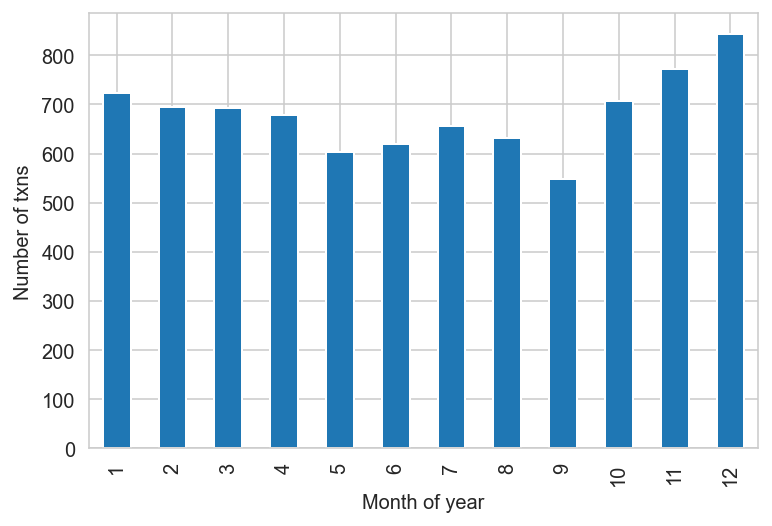

In [68]:
dfs.date.dt.month.value_counts().sort_index().plot(
    kind="bar", xlabel="Month of year", ylabel="Number of txns"
);

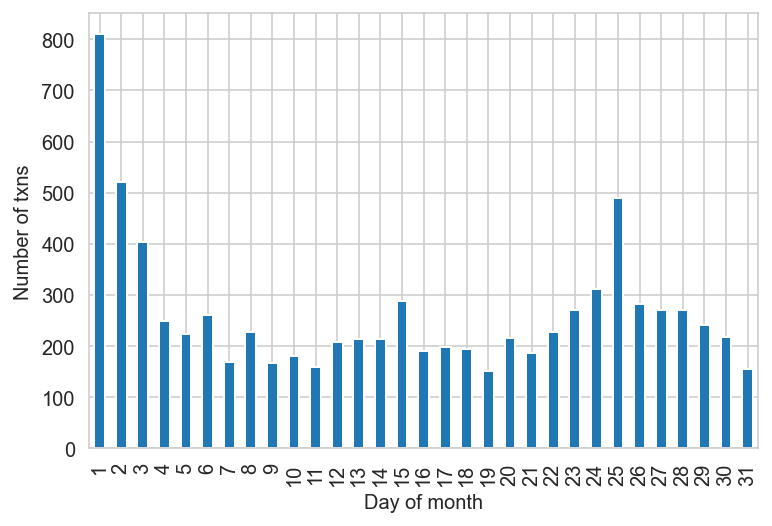

In [69]:
dfs.date.dt.day.value_counts().sort_index().plot(
    kind="bar", xlabel="Day of month", ylabel="Number of txns"
);

Distribution above somewhat resembles that for income payment, suggesting that (some) people do make transfers into SA right after they receive their salary.

### Number of inflows per day

In [70]:
dfs.groupby(["user_id", "date"]).size().describe(
    percentiles=[0.7, 0.75, 0.8, 0.9, 0.95, 0.99]
)

count    5417.000000
mean        1.508399
std         1.559733
min         1.000000
50%         1.000000
70%         1.000000
75%         1.000000
80%         2.000000
90%         2.000000
95%         4.000000
99%         9.000000
max        31.000000
dtype: float64

What happens on days of multiple transfers?

In [71]:
dfs.groupby(["user_id", "date"]).filter(lambda g: len(g) > 1).head(4)

,date,user_id,amount,desc,merchant,tag_group,tag,account_id,account_last_refreshed,account_provider,account_type,debit,desc_orig,female,id,latest_balance,postcode,tag_auto,yob,is_salary_pmt,is_sa_inflow
6054,2019-02-11,777,120.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,from a/c xxxx5781 via mobile - xfer - dpc,0.0,512170715,164.690002,wa1 4,transfers,1969.0,False,True
6055,2019-02-11,777,60.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,from a/c xxxx5781 via mobile - xfer - dpc,0.0,512170716,164.690002,wa1 4,transfers,1969.0,False,True
6087,2019-02-25,777,250.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,from a/c xxxx5781 via mobile - xfer - dpc,0.0,518477468,164.690002,wa1 4,transfers,1969.0,False,True
6088,2019-02-25,777,100.0,from a c 5781 via mobile xfer,NaN,transfers,other_transfers,819747,2019-09-10 13:47:00,natwest bank,savings,False,from a/c xxxx5781 via mobile - xfer - dpc,0.0,518477469,164.690002,wa1 4,transfers,1969.0,False,True


### What amounts are being transferred?

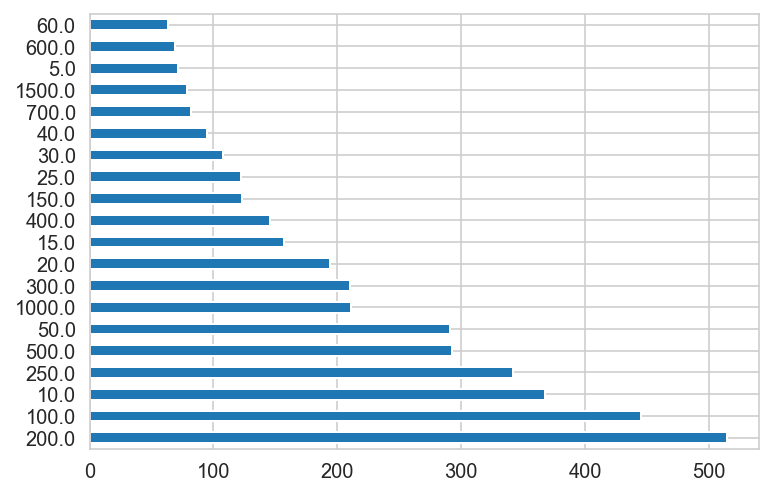

In [72]:
dfs.amount.value_counts().head(20).plot(kind="barh");

Amounts correspond to the kind of savings I'm interested in.

### How frequently do inflows happen?

Group by user-date to get number of days between transfers and ignore multiple transfers on the same day.

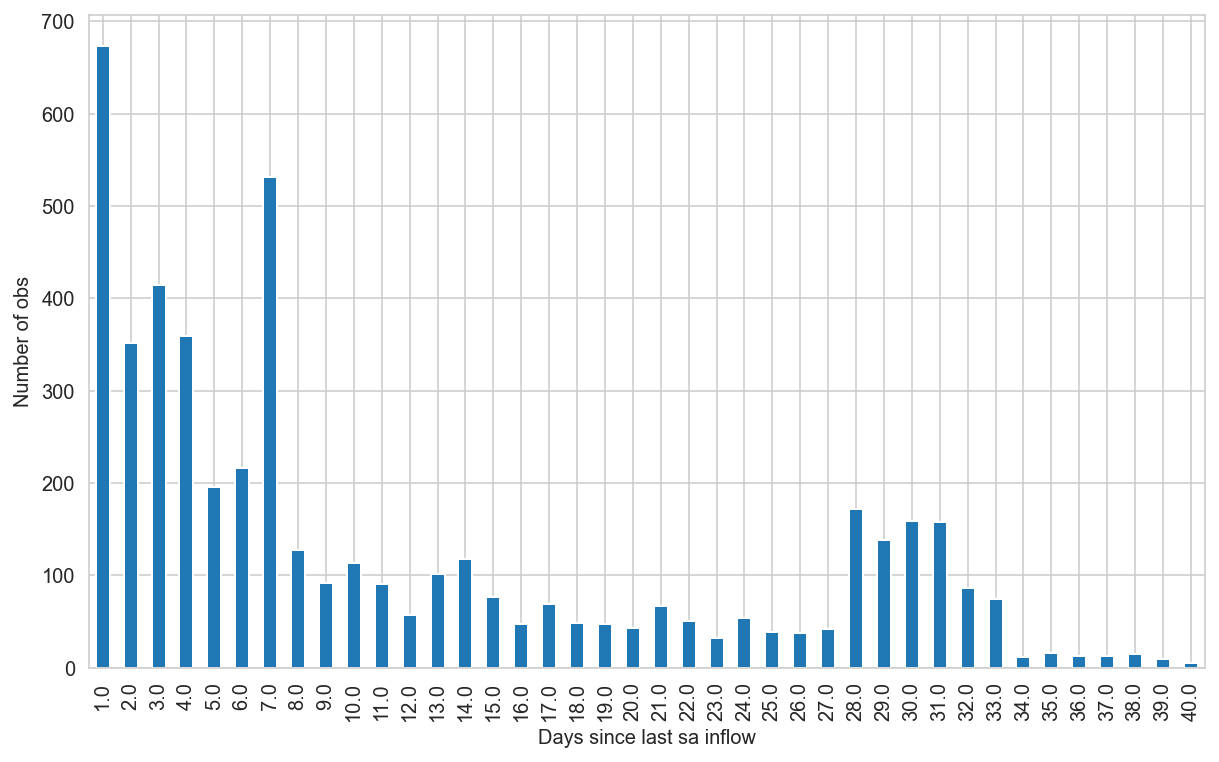

In [91]:
dfs.groupby(["user_id", "date"], as_index=False).amount.sum().groupby(
    "user_id"
).date.diff().dt.days.value_counts().sort_index().head(40).plot(
    kind="bar",
    figsize=(10, 6),
    xlabel="Days since last sa inflow",
    ylabel="Number of obs",
);

Distribution suggests that there are users who make regular weekly and monthly payments, a pattern resembling receipt of salary. So these people might indeed make transfers after receiveing their salary.

## Salary payments

About 0.8 percent of txns are salary payments.

In [66]:
df.is_salary_pmt.astype("int").describe()

count    649817.000000
mean          0.008125
std           0.089774
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_salary_pmt, dtype: float64

### Summary stats of number and amount of monthly income payments

In [102]:
def income_pmts_per_month(df):
    df = df.copy()
    df["amount"] = df.amount * -1
    month = pd.Grouper(key="date", freq="m")
    return (
        df.loc[df.is_salary_pmt]
        .groupby(["user_id", month])
        .amount.agg([("txns", "count"), ("income", "sum")])
        .groupby("user_id")
        .agg(
            [
                "mean",
                "median",
                "min",
                "max",
                "std",
                "size",
            ]
        )
    )


income_pmts_per_month(df).loc[lambda df: df[("txns", "size")] >= 6].describe().T

count         mean          std         min          25%  \
txns   mean    145.0     1.422332     0.926269    1.000000     1.000000   
       median  145.0     1.327586     0.952663    1.000000     1.000000   
       min     145.0     1.096552     0.430183    1.000000     1.000000   
       max     145.0     2.234483     1.932952    1.000000     1.000000   
       std     145.0     0.353411     0.602641    0.000000     0.000000   
       size    145.0    25.765517    16.786243    6.000000    13.000000   
income mean    145.0  2181.339111  1684.026611  259.821442  1170.821655   
       median  145.0  2037.676025  1614.561646  168.750000  1162.645020   
       min     145.0  1272.845337   989.228943    0.880000   430.420013   
       max     145.0  4415.877441  5645.400391  607.500000  1754.660034   
       std     145.0   762.191553  1245.436296    0.000000   176.390946   
       size    145.0    25.765517    16.786243    6.000000    13.000000   

                       50%          75%           max  
txns   mean       1.000000     1.300000      7.055556  
       median     1.000000     1.000000      7.500000  
       min        1.000000     1.000000      4.000000  
       max        1.000000     2.000000     12.000000  
       std        0.000000     0.479463      4.345007  
       size      22.000000    35.000000    100.000000  
income mean    1840.271973  2561.570557  13070.717773  
       median  1794.099976  2360.439941  14591.049805  
       min     1138.040039  1890.510010   4757.680176  
       max     2580.899902  4404.000000  35766.128906  
       std      394.008134   641.755887   7644.722648  
       size      22.000000    35.000000    100.000000

### When do salary payments arrive?

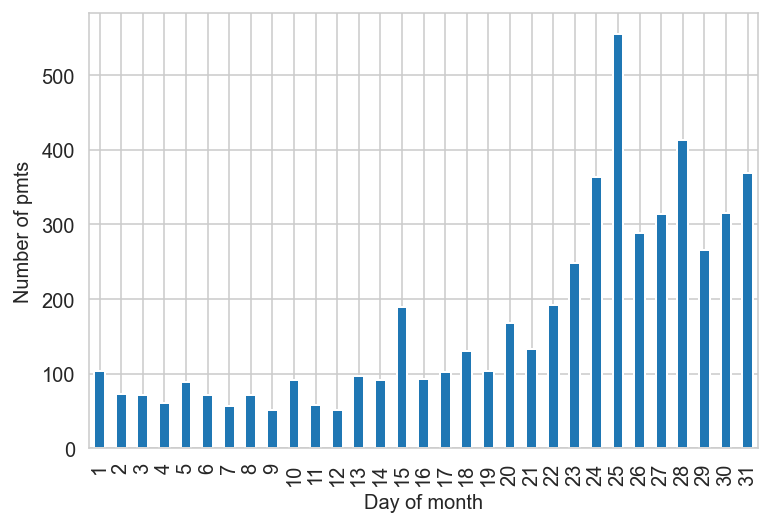

In [67]:
df[df.is_salary_pmt].date.dt.day.value_counts().sort_index().plot(
    kind="bar", xlabel="Day of month", ylabel="Number of pmts"
);

### How frequently do salary payments arrive?

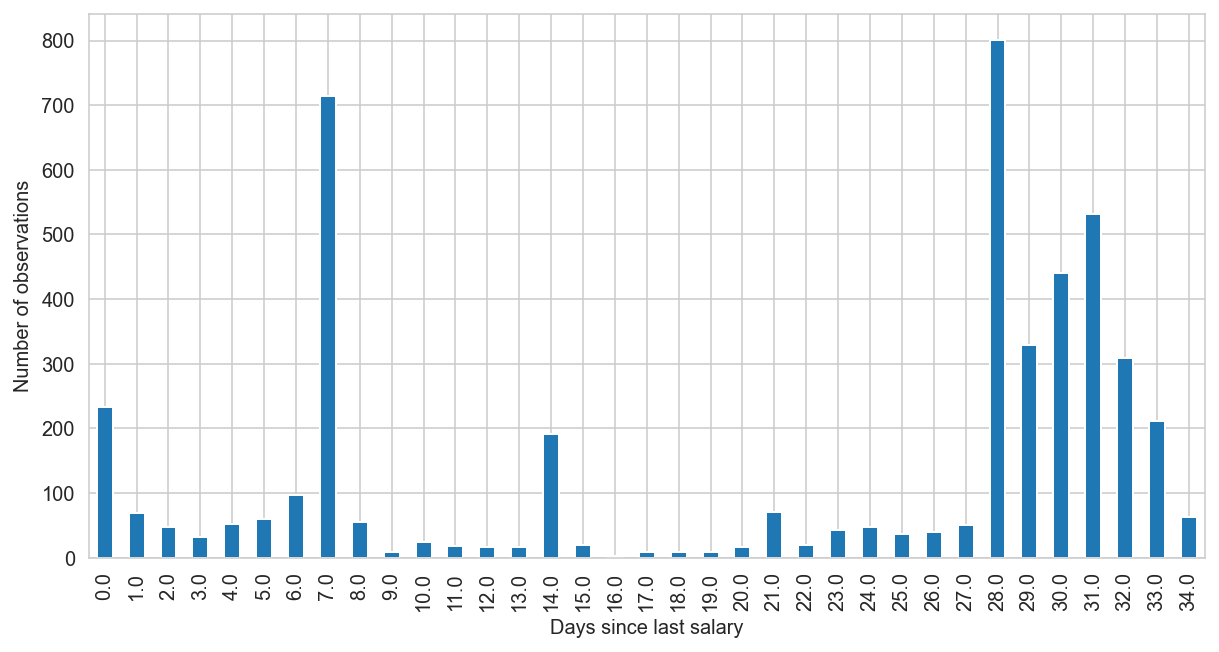

In [132]:
def days_since_last_salary(df):
    return (
        df[df.is_salary_pmt]
        .sort_values(["user_id", "date"])
        .groupby("user_id")
        .date.diff()
        .dt.days
    )


days_since_last_salary(df).pipe(
    hd.trim, pct=5, how="upper"
).value_counts().sort_index().plot(
    kind="bar",
    xlabel="Days since last salary",
    ylabel="Number of observations",
    figsize=(10, 5),
);

## Salary and savings